# Sprint2_AlexanderChen

In the last sprint we have validated the following parameters:

* Elevation ( downhill / level / uphill )
* Driving area (city / high way / dirt road) 

And we came to the conclusion that we could not validate the dataset which would aid us in parameter:

* driving style (aggressive acceleration / aggressive braking / aggressive turning)

I then proposed the idea of using the already validated parameter for **driving area** which is *speed_OBD* in the database. By taking the first three seconds of each moment that the car stopped and averaging the results.               The choise for I 3 rows representing 3 seconds in arbitrary.
The timestamp corresponds to the first row of *actual* velocity. 


I will test this on **car1** in this notebook, to test the code. However, During the development of I encountered some technical limitations:

* python has a limit on tail recursion, which limits the amount of data I can analyse
* jupyter notebooks has a data throughput limit, which also limit the amount of data that can be analysed. 

Therefore, we can only analyse 11950 rows, since after that either the notebooks or python starts becoming unreliable. I want to 'brush up' on my recursive programming skills, this could mean that in a production envirroment another form is better.

In [19]:
# importing pandas for the dataframes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# output to notebook
%matplotlib inline

#importing sys to increase the recursion limit, 
import sys
sys.setrecursionlimit(25000)

#importing the higher function reduce for a specific part of the code
from functools import reduce


#the proces ID to get into bigquery, this information cannot be shared since this is an active startup 'Headingon'
projectid = "vast-art-**********"



In [20]:
#this is the main interacting function, cascadingly calling the remain two other function
def shell_function (vehicle_name, starting_row):
    #making a list to hold the found data
    global average_acceloration_vehicle
    average_acceloration_vehicle = []
    
    #limiting the rows 
    count_of_rows = 11950
    
    #the query to bigquery and readjusting the format
    query_df = pd.read_gbq("select * from [headingon_params.speed_obd] where vehicle ='%s' order by timestamp ASC limit 11950" %vehicle_name, projectid)
    transit_df = query_df.drop(['fullname', 'unit'], axis=1)
    column_indicators= ['timestamp', 'value', 'vehicle']
    main_df = transit_df[column_indicators]
    
    return filter_function(vehicle_name, 0, count_of_rows, main_df, average_acceloration_vehicle)
    

In [21]:
#this function crawls over the entire list and filters which part needs to be copied and which can be discarded
def filter_function(vehicle_name,row, end, dataframe, car_list):
    #the basecase
    if row >= end:
        return car_list
    else:
        #these two if-statements ensures that right rows are identified
        if dataframe.iloc[row,1] == 0.0:
            row_add = row + 1
            if dataframe.iloc[row_add, 1] != 0.0:
                row+=1
                return core_function(vehicle_name, row, end, dataframe, car_list)
            else:
                row+=1
                return filter_function(vehicle_name, row, end, dataframe, car_list)
        else:
            row+=1
            return filter_function(vehicle_name, row, end, dataframe, car_list)
    


    

In [22]:
#this is the core of the operation,hence the name,it extracts the needed data and makes takes the average.
def core_function(vehicle_name, row, end, dataframe, car_list):
    temp_list = []
    timestamp = dataframe.iat[row,0]
    for i in range(3):
        temp_list.append(dataframe.iat[row,1])
        row+=1
    average_km = (reduce((lambda x, y: x+y), temp_list) / 3) 
    car_list.append({'timestamp': timestamp, 'value': average_km, 'vehicle': vehicle_name})
    row+=1
    return filter_function(vehicle_name, row, end, dataframe, car_list)

Now i can run the function and see the results


In [7]:
shell_function('car1', 0 )

Requesting query... ok.
Job ID: job_hf8yketjLPSSPeU54u-KVrHPsfKp
Query running...
Query done.
Processed: 32.4 MB
Standard price: $0.00 USD

Retrieving results...
Got 11950 rows.

Total time taken 2.51 s.
Finished at 2017-10-21 17:07:06.


[{'timestamp': Timestamp('2016-09-30 17:36:19'),
  'value': 2.0,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:36:50'),
  'value': 7.0,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:40:58'),
  'value': 20.0,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:42:18'),
  'value': 4.666666666666667,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:42:52'),
  'value': 4.0,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:43:08'),
  'value': 6.333333333333333,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:43:32'),
  'value': 3.6666666666666665,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:44:02'),
  'value': 4.333333333333333,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:44:29'),
  'value': 2.6666666666666665,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:45:48'),
  'value': 5.333333333333333,
  'vehicle': 'car1'},
 {'timestamp': Timestamp('2016-09-30 17:46:

Let's look at the output properly so we can assess if it works

In [23]:
pd.DataFrame(average_acceloration_vehicle).head()

,timestamp,value,vehicle
0,2016-09-30 17:36:19,2.000000,car1
1,2016-09-30 17:36:50,7.000000,car1
2,2016-09-30 17:40:58,20.000000,car1
3,2016-09-30 17:42:18,4.666667,car1
4,2016-09-30 17:42:52,4.000000,car1


When comparing them to the actual data of the bidquery the head par matched up. So now lets do the same for tail

In [24]:
pd.DataFrame(average_acceloration_vehicle).head()

,timestamp,value,vehicle
0,2016-09-30 17:36:19,2.000000,car1
1,2016-09-30 17:36:50,7.000000,car1
2,2016-09-30 17:40:58,20.000000,car1
3,2016-09-30 17:42:18,4.666667,car1
4,2016-09-30 17:42:52,4.000000,car1


Here too the algorithm seems to work as i wanted it to. Now the next step is to verify that the the average values are reliable. For instance look at the below information.

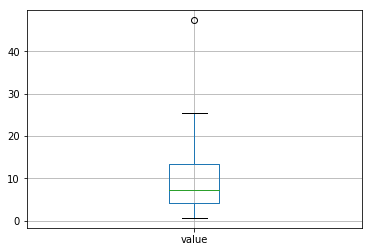

In [25]:
average_acceloration_vehicle_df= pd.DataFrame(average_acceloration_vehicle)
average_acceloration_vehicle_df.boxplot()
plt.show()

Now that I know the program extracts the right data, it seems that the next step is to preform some statistical transformations to make sure that I can use it properly. This is actually trickier to get conlusive then the programming part. But will be the follow up.